# Outliers and Leverages

Another important step in the EDA process is detecting and dealing with outliers in the data.

An outlier is a data point that differs massively to the other data points - it is the 'odd one out' as such.

In [187]:
from db_utils import DataTransform, DataFrameInfo, Plotter, DataFrameTransforms, save_changes

dt = DataTransform()
df_info = DataFrameInfo()
visualise = Plotter()
transform = DataFrameTransforms()

df = dt.read_data('skew_data.csv')

There are many ways to detect outliers but the best way to visually see them is by using the Box Plot with scatter points. The outliers will sit clearly outside of the range of the box plot.

First, I would like to visualise those columns which already have a moderate skew within -0.5 and 0.5 after our previous transformations.

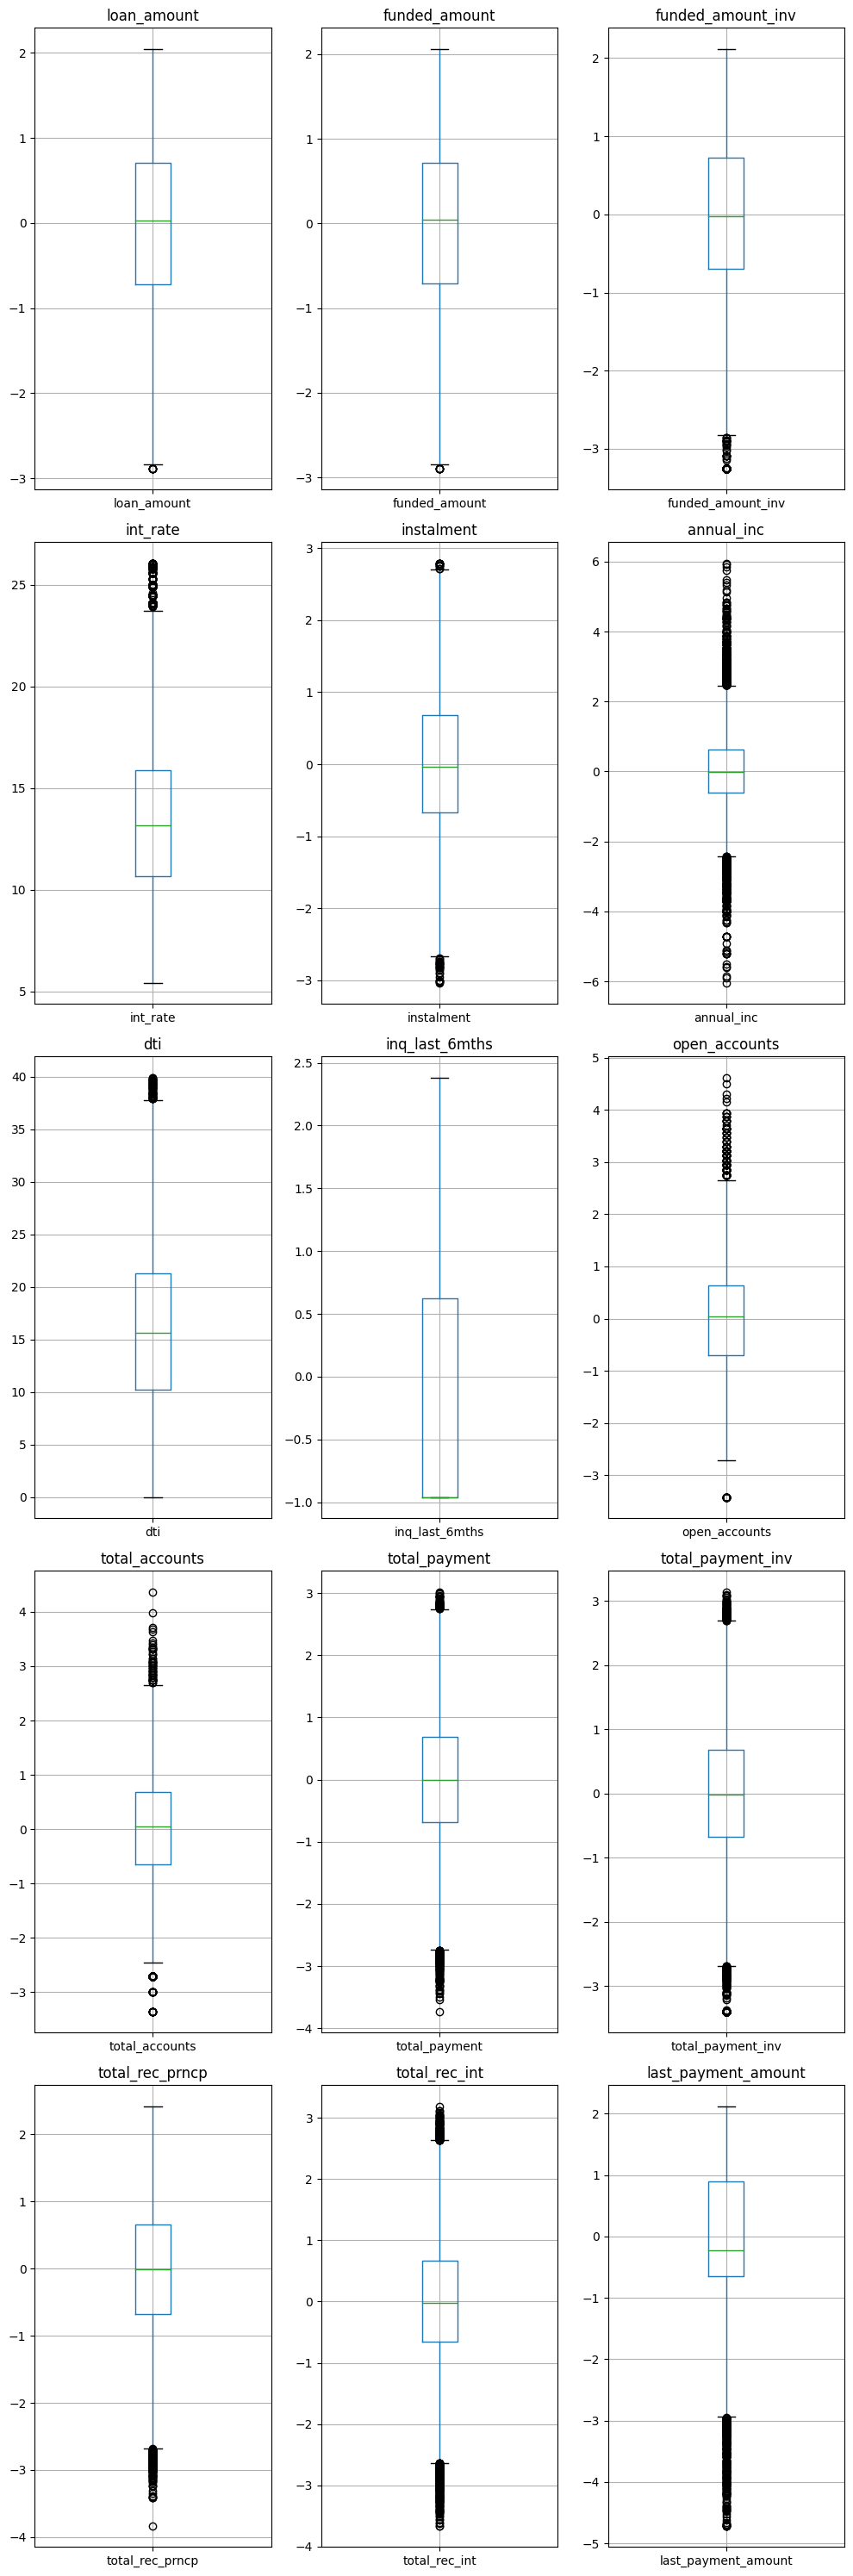

In [189]:
columns = ['loan_amount', 'funded_amount', 'funded_amount_inv', 'int_rate', 'instalment', 'annual_inc', 'dti', 'inq_last_6mths', 'open_accounts', 'total_accounts', 'total_payment', 'total_payment_inv', 'total_rec_prncp', 'total_rec_int', 'last_payment_amount']

visualise.box_plots(df, columns, 5, 3)

There are many data points that lie outside of the box plots. However, I don't want to just remove all of these as they could be legit and valuable data points.

I will look into some of the categorical columns, starting with `home_ownership`:

In [190]:
df['home_ownership'].value_counts()

MORTGAGE    26903
RENT        22441
OWN          4742
OTHER          63
NONE            2
Name: home_ownership, dtype: int64

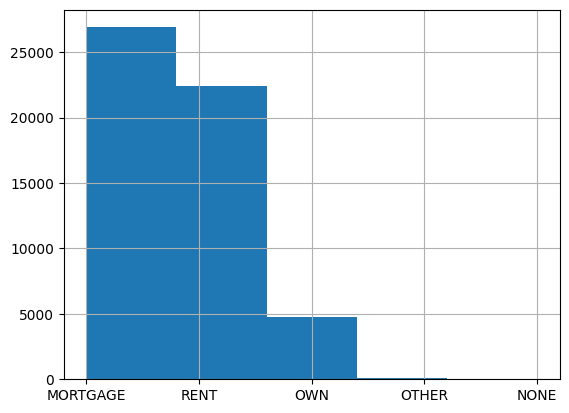

In [191]:
visualise.histogram(df, 'home_ownership', 5)

I can see here that there are 2 outliers sitting in the 'NONE' category. Instead of deleting these, I am going to replace them with 'OTHER', combining the two categories. This way I am not removing any data. 

There were 63 values in 'OTHER', and now there are 65 so I know the replacement was successful.

In [192]:
df['home_ownership'] = df['home_ownership'].replace('NONE', 'OTHER')

df['home_ownership'].value_counts()

MORTGAGE    26903
RENT        22441
OWN          4742
OTHER          65
Name: home_ownership, dtype: int64

`delinq_2yrs`:

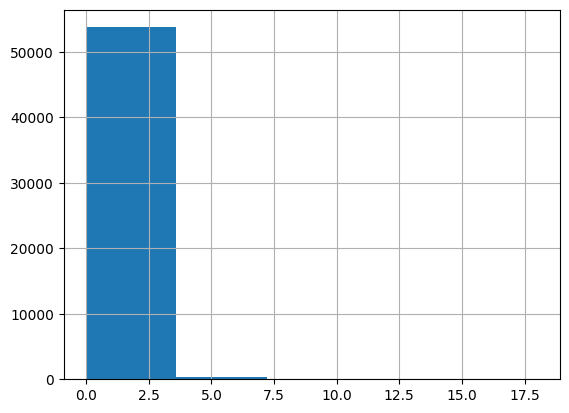

In [193]:
visualise.histogram(df, 'delinq_2yrs', 5)

There are quite a few values plotted around the maximum value. The skew for this variable is 5.376 and so I will need to deal with these outliers before the data is sent to be used in any models.

This column is not going to be relevant for the model the data is going to be used for and so I am happy that the outliers can be removed. I am going to use the IQR method to remove the outliers and reduce the skew to 0:

In [194]:
outlier_df = transform.remove_IQR_outliers(df, 'delinq_2yrs')

Lower limit: 0.0
Upper limit: 0.0
IQR: 0.0


In [195]:
outlier_df['delinq_2yrs'].skew()

0

The skew is now zero.

The next method I am going to use to remove outliers is the Z-score method. This method finds the Z-score and removes any outliers outside of the threshold given.

Generally speaking, a Z-Score within -3.0 and 3.0 is acceptable.

In [196]:
df['total_accounts'].skew()

-0.012624930976857072

`total_accounts` already has minimal skew and so I am going to use the Z-Score method here and set the threshold to 2 to bring the skew as close to 0 as possible.

I am only going to action this as `total_accounts` is not a valuable variable for the analysis I am going to be doing on this dataset.

If `total_accounts` was a key factor in my analysis, I would not remove any of the outliers as the skew is acceptable at -0.0126.

In [197]:
outlier_df = transform.remove_zscore_outliers(df, 'total_accounts', 2)

outlier_df['total_accounts'].skew()

0.0007988958632675587

By using the Z-Score method, the skew is now extremely close to zero and contains no outliers which is visable in the Box Plot below.

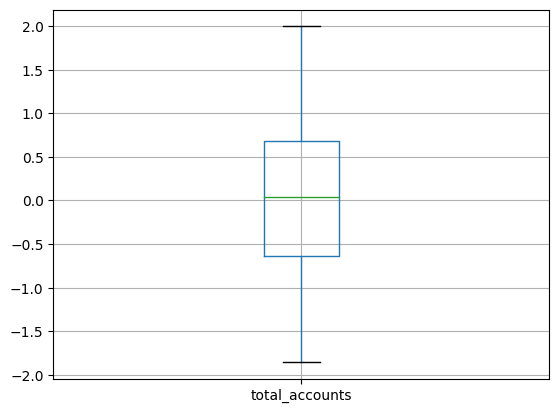

In [198]:
visualise.one_boxplot(outlier_df, 'total_accounts')

By looking at the following Box Plot for `total_rec_late_fee`, I can see that there is one clear outlier sitting above 350. I would like to remove only this data point as the other data points outside of the IQR look like valid data points. And so if I remove those too, it will reduce the accuracy in our data.

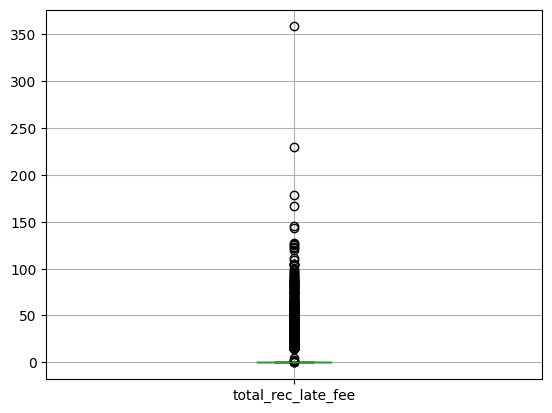

In [199]:
visualise.one_boxplot(df, 'total_rec_late_fee')

I have created a method to remove only values outside of a selected range. In this case I am going to specify 350 to reduce the max value as it is a clear outlier.

In [200]:
outlier_df = transform.remove_certain_value_outliers(df, 'total_rec_late_fee', 350)

In [201]:
save_changes(outlier_df, 'outlier_loan_data.csv')